In [1]:
%matplotlib inline
import matplotlib.pyplot as plt




In [2]:
import Odorant_Stim_fourodors


In [19]:
import csv
import collections

def read_connections(filename):
    #r = list(csv.reader(open('erecta_picky_circuitry_absolute.csv'))) #Need to get updated connectivity from Ruairi with all neurons
    r = list(csv.reader(open('updated_melanogaster_all_circuitry_absolute.csv'))) #does this need to be changed to 'filename'?

    header = r[0]
    data = r[1:]

    conns = {}
    for row in data:
        for i, item in enumerate(row):
            if i > 0:
                pre = row[0]
                post = header[i]
                c = int(item)
                if c > 0:
                    if pre not in conns:
                        conns[pre] = {}
                    conns[pre][post] = c
                    
    ORNs_left = [name for name in header if 'ORN' in name and 'left' in name]
    ORNs_right = [name for name in header if 'ORN' in name and 'right' in name]
    uPNs_left = [name for name in header if ' uPN' in name and 'left' in name]
    uPNs_right = [name for name in header if ' uPN' in name and 'right' in name]
    mPNs_left = [name for name in header if 'mPN' in name and 'left' in name]
    mPNs_right = [name for name in header if 'mPN' in name and 'right' in name]
    Pickys_left = [name for name in header if 'icky' in name and 'left' in name]
    Pickys_right = [name for name in header if 'icky' in name and 'right' in name]

    assert (len(ORNs_left)+len(ORNs_right)+len(uPNs_left)+len(uPNs_right)+
            len(mPNs_left)+len(mPNs_right)+len(Pickys_left)+len(Pickys_right) == (21*4+15*2+5*2))
                         
    Names = collections.namedtuple('Names', ['ORNs_left', 'uPNs_left', 'mPNs_left', 'Pickys_left'])
    return conns, Names(ORNs_left, uPNs_left, mPNs_left, Pickys_left)

def make_weights(conns, pre, post):
    w = np.zeros((len(post), len(pre))) #note: pre/post switched in output array for print(make_weights())
    for i, pre_n in enumerate(pre):
        for j, post_n in enumerate(post):
            if post_n in conns[pre_n]:
                w[j,i] = conns[pre_n][post_n] 
    return w



In [4]:
import nengo
import numpy as np
import scipy.interpolate

def compute_rate_to_current(neuron_model=nengo.LIFRate(), max_current=10.0):
    tuning_model = nengo.Network()
    with tuning_model:
        N = 1
        T = 10
        max_current = 10.0
        n = nengo.Ensemble(n_neurons=N, dimensions=1,
                           neuron_type=nengo.LIFRate(),
                           gain=[1]*N, bias=[0]*N,
                           )

        stim = nengo.Node(lambda t: t/T*max_current)
        nengo.Connection(stim, n.neurons, transform=np.ones((N, 1)), synapse=None)
        p_rate = nengo.Probe(n.neurons)
        p_current = nengo.Probe(stim)
    sim = nengo.Simulator(tuning_model, progress_bar=False)
    with sim:
        sim.run(T)
    rate_to_current = scipy.interpolate.interp1d(sim.data[p_rate][:,0], sim.data[p_current][:,0])
    return rate_to_current




In [20]:
import pytry
import Odorant_Stim_fourodors
import seaborn as sns

class PickyTrial(pytry.PlotTrial):
    def params(self):
        self.param('species (melanogaster|erecta)', species='melanogaster')
        self.param('concentration of odorant (log scale)', concentration=-2)
        self.param('odorant (geranyl acetate|anisole|2-heptanone)', odorant='anisole')
        self.param('synapse strength for ORN to uPN/mPN', w_ORN_PN=0.002)
        self.param('synapse strength for ORN to Picky', w_ORN_Picky=0.0005)
        self.param('synapse strength for Picky to uPN/mPN', w_Picky_PN=0.05)
        self.param('maximum OR rate', max_rate_OR=35.0)
        self.param('background OR rate', background_rate_OR=6.0)
        
    def evaluate(self, p, plt):
        
        conns, names = read_connections('updated_'+p.species+'_all_circuitry_absolute.csv')
        
        
        
        rate_to_current = compute_rate_to_current()

        model = nengo.Network(seed=p.seed)
        with model:
            stims = [-20,-20,p.concentration,-20,-20]
            log_concentrations = nengo.Node(nengo.processes.PresentInput(stims, presentation_time=5))

            def logconc_to_conc_func(t, x):              
                return 10**x     
            concentrations = nengo.Node(logconc_to_conc_func, size_in=1)

            def OR_func(t, x):
                rel = Odorant_Stim_fourodors.convert_compounds_to_responses(x)     
                max_rate = p.max_rate_OR
                background_rate = p.background_rate_OR
                return rate_to_current(rel*max_rate+background_rate)

            l_ORN_current = nengo.Node(OR_func, size_in=4)
            l_ORN = nengo.Ensemble(n_neurons=len(names.ORNs_left), dimensions=1,
                                   neuron_type=nengo.LIF(),
                                   noise=nengo.processes.WhiteNoise(nengo.dists.Gaussian(0,0.02)),
                                   gain=[1]*len(names.ORNs_left), bias=[0]*len(names.ORNs_left))
            nengo.Connection(l_ORN_current, l_ORN.neurons, synapse=None)
            l_uPN = nengo.Ensemble(n_neurons=len(names.uPNs_left), dimensions=1,
                                   gain=np.ones(len(names.uPNs_left)), bias=np.zeros(len(names.uPNs_left)))
            l_mPN = nengo.Ensemble(n_neurons=len(names.mPNs_left), dimensions=1,
                                   gain=np.ones(len(names.mPNs_left)), bias=np.zeros(len(names.mPNs_left)))
            l_Picky = nengo.Ensemble(n_neurons=len(names.Pickys_left), dimensions=1,
                                   gain=np.ones(len(names.Pickys_left)), bias=np.zeros(len(names.Pickys_left)))

            nengo.Connection(log_concentrations, concentrations, synapse=None)
            
            odorant_index = ['geranyl acetate', 'anisole', '2-heptanone', 'menthol'].index(p.odorant)
            nengo.Connection(concentrations, l_ORN_current[odorant_index], synapse=nengo.synapses.Alpha(1))

            nengo.Connection(l_ORN.neurons, l_uPN.neurons, 
                             transform=p.w_ORN_PN*make_weights(conns, names.ORNs_left, names.uPNs_left), 
                             synapse=0.01)
            nengo.Connection(l_ORN.neurons, l_mPN.neurons, 
                             transform=p.w_ORN_PN*make_weights(conns, names.ORNs_left, names.mPNs_left),
                             synapse=0.01)
            nengo.Connection(l_ORN.neurons, l_Picky.neurons, 
                             transform=p.w_ORN_Picky*make_weights(conns, names.ORNs_left, names.Pickys_left),
                             synapse=0.01)
            nengo.Connection(l_Picky.neurons, l_uPN.neurons, 
                             transform=-p.w_Picky_PN*make_weights(conns, names.Pickys_left, names.uPNs_left),
                             synapse=0.01)
            nengo.Connection(l_Picky.neurons, l_mPN.neurons, 
                             transform=-p.w_Picky_PN*make_weights(conns, names.Pickys_left, names.mPNs_left),
                             synapse=0.01)

            p_Picky = nengo.Probe(l_Picky.neurons)
            p_stim = nengo.Probe(concentrations)
            p_uPN = nengo.Probe(l_uPN.neurons)
            p_mPN = nengo.Probe(l_mPN.neurons)
            p_ORN = nengo.Probe(l_ORN.neurons)

        sim = nengo.Simulator(model, seed=p.seed+1)
        sim.run(25)
        
        data_ORN = sim.data[p_ORN]
        data_uPN = sim.data[p_uPN]
        data_mPN = sim.data[p_mPN]
        data_Picky = sim.data[p_Picky]

        result = dict(
            responses_ORN=np.mean(data_ORN.T.reshape(len(names.ORNs_left), 50, 500), axis=2),
            responses_uPN=np.mean(data_uPN.T.reshape(len(names.uPNs_left), 50, 500), axis=2),
            responses_mPN=np.mean(data_mPN.T.reshape(len(names.mPNs_left), 50, 500), axis=2),
            responses_Picky=np.mean(data_Picky.T.reshape(len(names.Pickys_left), 50, 500), axis=2),
        )
        if plt:
            fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12,16))
            sns.heatmap(result['responses_ORN'], cmap='Greens', yticklabels= names.ORNs_left, ax=ax1, square=True)
            sns.heatmap(result['responses_uPN'], cmap='Blues', yticklabels= names.uPNs_left, ax=ax2, square=True)
            sns.heatmap(result['responses_mPN'], cmap='Oranges', yticklabels= names.mPNs_left, ax=ax3, square=True)
            sns.heatmap(result['responses_Picky'], cmap='Reds', yticklabels= names.Pickys_left, ax=ax4, square=True)
            for i, ax in enumerate([ax1,ax2,ax3,ax4]):
                ax.axvline(x=20, color='gray')
                ax.axvline(x=30, color='gray')
                ax.set_xticks([20,30])
                ax.set_xticklabels(['['+str(p.concentration)+'] ON', '['+str(p.concentration)+'] OFF'], rotation=0)
            
        return result 
        
        


In [7]:
print(PickyTrial().show_params())

background_rate_OR: background OR rate (default=6.0)
     concentration: concentration of odorant (log scale) (default=-2)
       max_rate_OR: maximum OR rate (default=35.0)
           odorant: odorant (geranyl acetate|anisole|2-heptanone) (default='anisole')
              seed: random number seed (default=1)
           species: species (melanogaster|erecta) (default='melanogaster')
          w_ORN_PN: synapse strength for ORN to uPN/mPN (default=0.002)
       w_ORN_Picky: synapse strength for ORN to Picky (default=0.0005)
        w_Picky_PN: synapse strength for Picky to uPN/mPN (default=0.05)
          data_dir: data directory (default='data')
     data_filename: filename for data (default='')
       data_format: data file format [txt,npz] (default='txt')
               plt: display plot (default=False)
       plt_overlay: show overlay on plot (default=False)
          plt_save: save plot (default=False)
           verbose: print progress information (default=True)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

<Figure size 432x288 with 0 Axes>

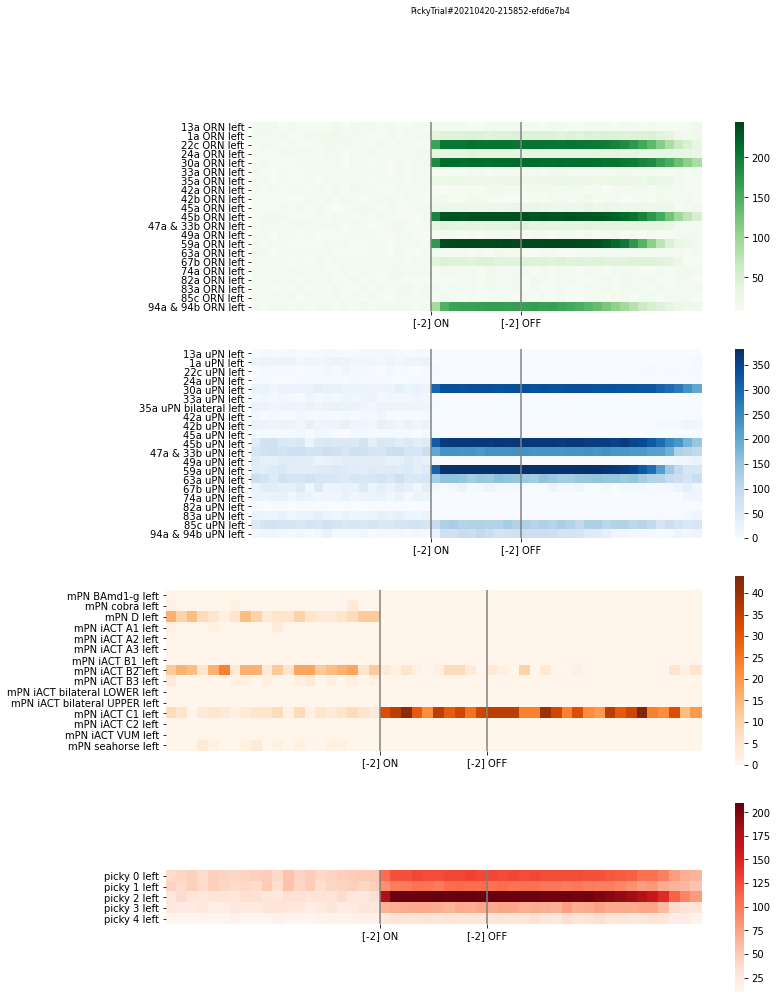

In [21]:
r = PickyTrial().run(background_rate_OR=10.0,max_rate_OR=45.0, plt=True, verbose=False)

In [53]:
for seed in range(3):
    print(seed)
    for w in [0, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005]:
        PickyTrial().run(plt=False, verbose=False, w_ORN_Picky=w, 
                         data_dir='exp1', data_format='npz', seed=seed)

0


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

1


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

2


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.